In [2]:
pwd

'C:\\Users\\admin\\Downloads'

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from keras import backend as K
from keras.layers import Input, Dense, Lambda, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Flatten
from keras.models import Model
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils import class_weight
import tensorflow as tf
import optuna
import mlflow
from mlflow.models import infer_signature
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [3]:
# Load and preprocess the dataset
def image_preprocessing():
    sclerotic_folder_path = "public/public/globally_sclerotic_glomeruli"
    non_sclerotic_folder_path = "public/public/non_globally_sclerotic_glomeruli"
    groundtruth_file_path = "public/public/public.csv"
    groundtruth_df = pd.read_csv(groundtruth_file_path)
    images = []
    labels = []

    for row in groundtruth_df.itertuples(index=False):
        label = row[1]
        filename = row[0]
        if label == 1:
            image_path = os.path.join(sclerotic_folder_path, filename)
        else:
            image_path = os.path.join(non_sclerotic_folder_path, filename)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (224, 224))  
        image = image / 255.0  
        images.append(image)
        labels.append(label)
        
    images = np.array(images)
    labels = np.array(labels)
    
    # Split the dataset into train and test sets
    strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_val_idx, test_idx = next(strat_split.split(images, labels))
    train_val_images, test_images = images[train_val_idx], images[test_idx]
    train_val_labels, test_labels = labels[train_val_idx], labels[test_idx]

    return train_val_images, train_val_labels, test_images, test_labels

In [8]:
train_val_images, train_val_labels, test_images, test_labels = image_preprocessing()

In [9]:
# Create the Encoder-Decoder model
def encoder_decoder(num_layers, activation_function, filter_counts, latent_dimension=3):
    input_layer = Input(shape=(224, 224, 3))
    x = input_layer

    # Encoder
    for i in range(num_layers):
        x = Convolution2D(filters=filter_counts[i], kernel_size=(3, 3), padding="same", activation=activation_function)(x)
        if i < num_layers - 1:
            x = MaxPooling2D((2, 2), padding='same')(x)

    shape_before_flattening = K.int_shape(x)  
    x = Flatten()(x)  
    z_mean = Dense(latent_dimension, name='z_mean')(x)
    z_log_var = Dense(latent_dimension, name='z_log_var')(x)
    z = Lambda(sampling, name='sampling')([z_mean, z_log_var])

    encoder = Model(input_layer, [z_mean, z_log_var, z], name='encoder')

    # Decoder
    decoder_input = Input(shape=(latent_dimension,))
    x = Dense(np.prod(shape_before_flattening[1:]), activation=activation_function)(decoder_input)
    x = Reshape((shape_before_flattening[1], shape_before_flattening[2], shape_before_flattening[3]))(x)  

    
    for i in reversed(range(num_layers - 1)):
        x = Convolution2D(filters=filter_counts[i], kernel_size=(3, 3), padding="same", activation=activation_function)(x)
        x = UpSampling2D((2, 2))(x)

    output_layer = Convolution2D(3, (3, 3), padding='same', activation='sigmoid')(x)
    decoder = Model(decoder_input, output_layer, name='decoder')

    # Classifier model
    z_decoded = decoder(z)
    classification_output = Dense(2, activation='softmax', name='classification_output')(z)
    vae_model = Model(input_layer, [classification_output, z_decoded], name='vae')

    return vae_model, encoder, decoder


In [10]:
# Sampling function for eager execution compatibility
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [11]:
# Computing the VAE loss
def vae_loss(inputs, decoded_output, z_mean, z_log_var):
    reconstruction_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(inputs, decoded_output), axis=(1, 2))
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
    return tf.reduce_mean(reconstruction_loss + kl_loss)

In [12]:
def vae_loss_parameters(z_mean, z_log_var):
    def loss(inputs, decoded_output):
        return vae_loss(inputs, decoded_output, z_mean, z_log_var)
    return loss

In [13]:
# Rebuild the vae model architecture
def buildvae_model():
    optimal_params = {
        "num_layers": 3,
        "filters_0": 39,
        "filters_1": 105,
        "filters_2": 21,
        "activation_function": "relu"
    }
    
    
    vae_model, encoder, decoder = encoder_decoder(
        num_layers=optimal_params["num_layers"],
        activation_function=optimal_params["activation_function"],
        filter_counts=[optimal_params[f"filters_{i}"] for i in range(optimal_params["num_layers"])]
    )
    
    
    z_mean, z_log_var, _ = encoder.output
    vae_model.compile(optimizer="adam", 
                      loss={'classification_output': 'categorical_crossentropy', 
                            'decoder': vae_loss_parameters(z_mean, z_log_var)},
                      metrics={'classification_output': ['accuracy', 
                                                         tf.keras.metrics.Precision(name='precision'), 
                                                         tf.keras.metrics.Recall(name='recall'), 
                                                         tf.keras.metrics.AUC(name='auc')]})
    return vae_model


model = buildvae_model()

model.load_weights('best_deployed_vae_model.h5')

In [13]:
for layer in model.layers:
    print(layer.name)


input_1
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
flatten
z_mean
z_log_var
sampling
classification_output
decoder


In [17]:
def compute_gradcam(model, image, class_index, last_conv_layer_name="conv2d_2"):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = Model([model.inputs], [last_conv_layer.output, model.output[0]])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_index]  

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [18]:
def display_gradcam(model, image, class_index, filename, vmin, vmax, layer_name="conv2d_8"):
    heatmap = compute_gradcam(model, image, class_index, layer_name)

    img = np.uint8(255 * image[0])  

    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_resized = np.expand_dims(heatmap_resized, axis=-1)

    
    overlay = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    final_image = cv2.addWeighted(overlay_rgb, 0.4, img, 0.6, 0)

    
    plt.imshow(final_image)
    plt.axis('off')
    
   
    cbar = plt.colorbar()
    cbar.ax.tick_params(size=0)  
    
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

In [19]:
all_heatmaps = []
correct_class_0 = 0
correct_class_1 = 0

for i in range(len(test_images)):
    if correct_class_0 >= 10 and correct_class_1 >= 10:
        break  
    
    test_image = np.expand_dims(test_images[i], axis=0) 
    true_label = test_labels[i]  

    predicted_class_index = np.argmax(model.predict(test_image)[0])

    if predicted_class_index == 0 and true_label == 0 and correct_class_0 < 10:
        heatmap = compute_gradcam(model, test_image, predicted_class_index)
        all_heatmaps.append(heatmap)
        correct_class_0 += 1

    elif predicted_class_index == 1 and true_label == 1 and correct_class_1 < 10:
        heatmap = compute_gradcam(model, test_image, predicted_class_index)
        all_heatmaps.append(heatmap)
        correct_class_1 += 1


In [20]:
global_vmin = np.min(all_heatmaps)
global_vmax = np.max(all_heatmaps)


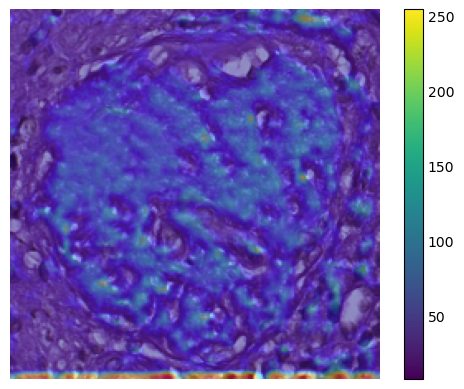

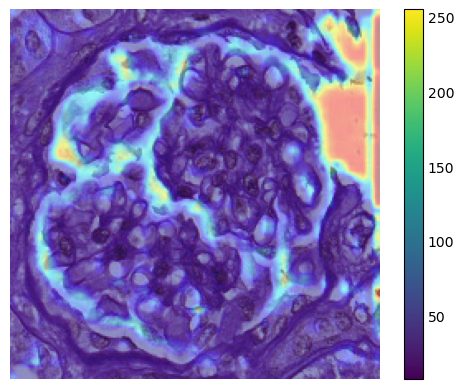

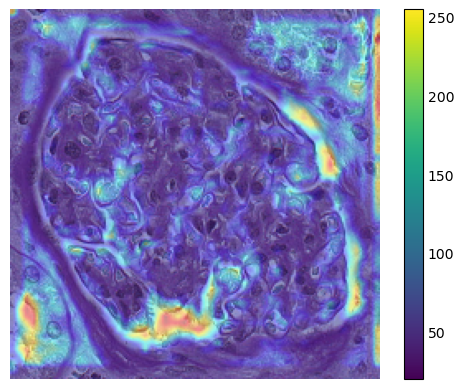

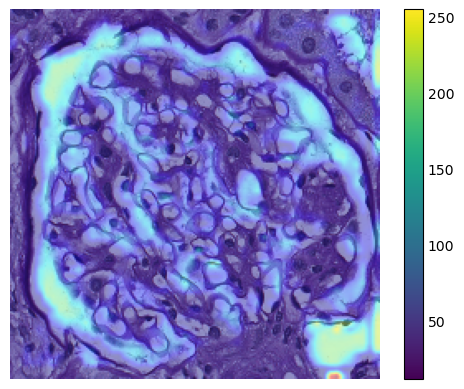

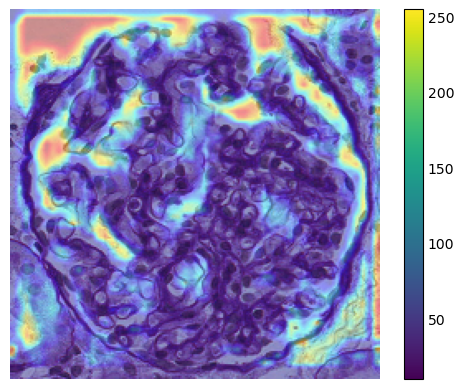

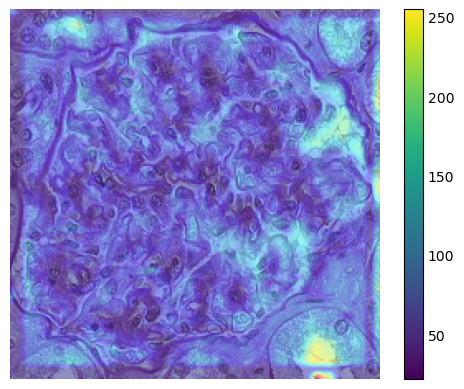

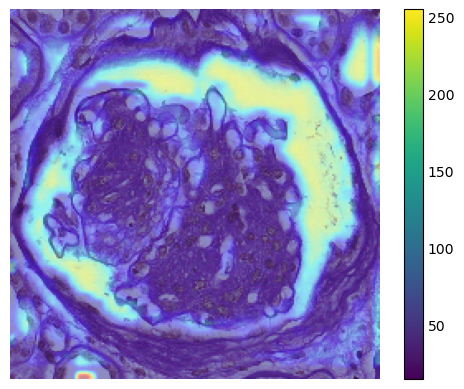

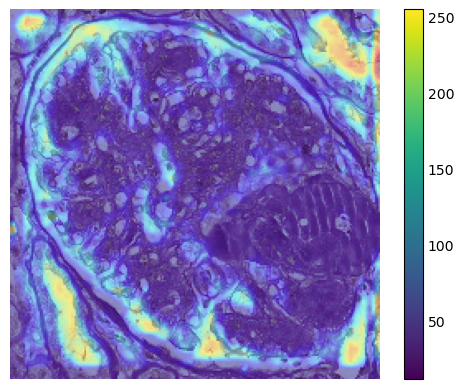

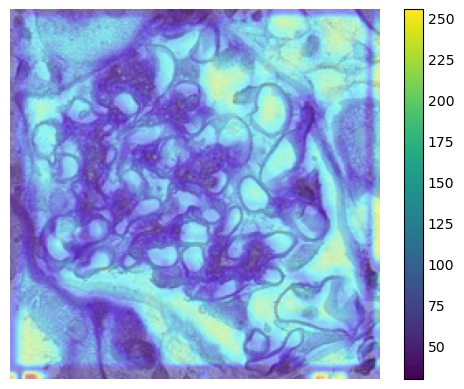

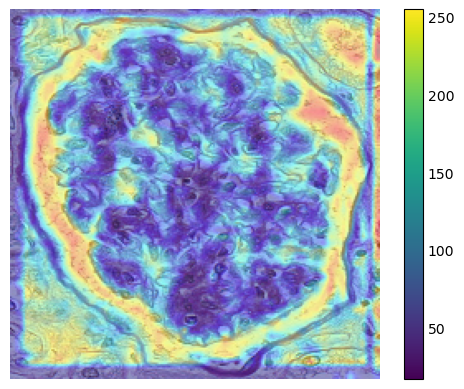

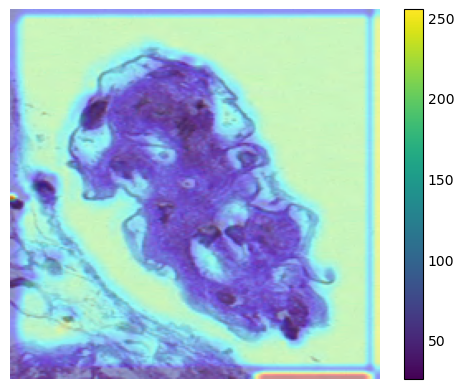

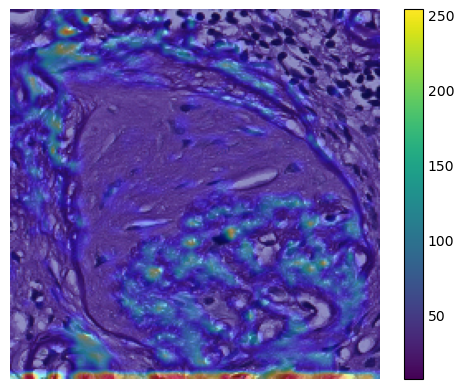

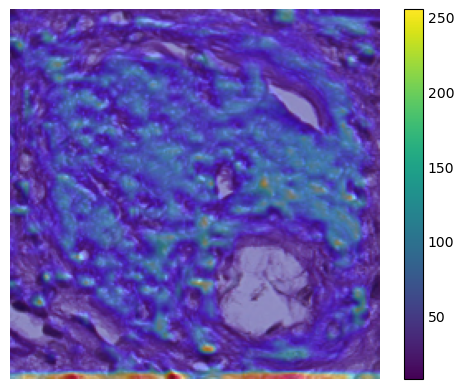

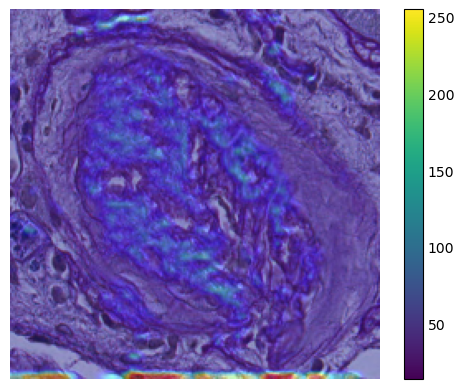

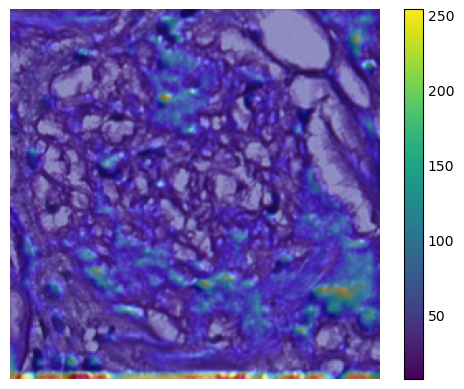

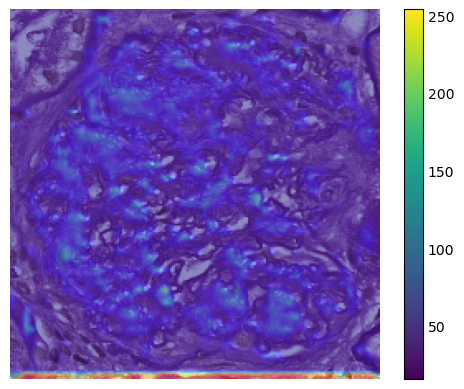

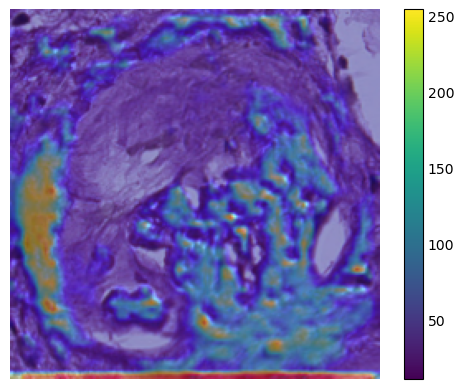

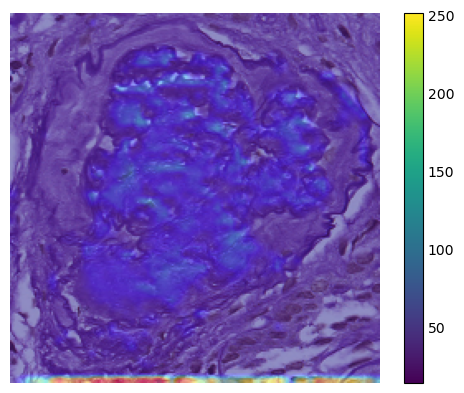

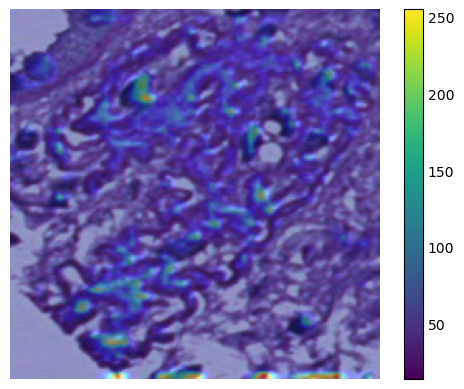

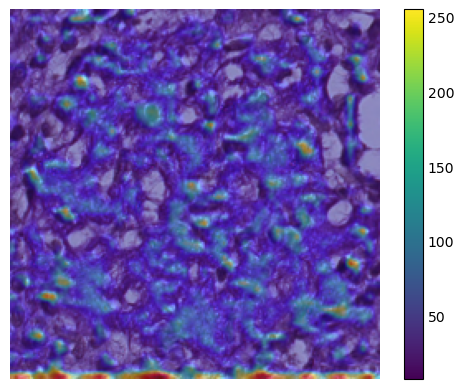

In [22]:
correct_class_0 = 0
correct_class_1 = 0

for i in range(len(test_images)):
    if correct_class_0 >= 10 and correct_class_1 >= 10:
        break  
    
    test_image = np.expand_dims(test_images[i], axis=0)  
    true_label = test_labels[i]  

    
    predicted_class = np.argmax(model.predict(test_image)[0])

    if predicted_class == 0 and true_label == 0 and correct_class_0 < 10:
        display_gradcam(model, test_image, predicted_class, filename=f'gradcam_class_0_img_{correct_class_0+1}.png', vmin=global_vmin, vmax=global_vmax, layer_name="conv2d_2")
        correct_class_0 += 1

    elif predicted_class == 1 and true_label == 1 and correct_class_1 < 10:
        display_gradcam(model, test_image, predicted_class, filename=f'gradcam_class_1_img_{correct_class_1+1}.png', vmin=global_vmin, vmax=global_vmax, layer_name="conv2d_2")
        correct_class_1 += 1